In [22]:
# %%time

# Bibliotecas usadas na análise
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

# Bibliotecas usadas na predição
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima

# Tratamento de Dados

In [2]:
%%time

# importando os dados
# !wget -c "https://data.brasil.io/dataset/covid19/caso_full.csv.gz"
covid19_df = pd.read_csv("caso_full.csv.gz", compression='gzip', header=0,sep=',', parse_dates=['date', 'last_available_date'])


# codificando as colunas para o data type correto
covid19_df['city_ibge_code'] = covid19_df['city_ibge_code'].astype(str).str[:-2]
covid19_df['epidemiological_week'] = covid19_df['epidemiological_week'].astype(str).str[:4] + '-' + covid19_df['epidemiological_week'].astype(str).str[4:]
covid19_df['estimated_population'].fillna('0.0', inplace=True)
covid19_df['estimated_population'] = covid19_df['estimated_population'].astype(float).astype(int)
covid19_df['estimated_population_2019'].fillna('0.0', inplace=True)
covid19_df['estimated_population_2019'] = covid19_df['estimated_population_2019'].astype(float).astype(int)

# removendo valores NaN da base
covid19_df.fillna('', inplace=True)

# Relaciona os códigos do IBGE com o nome da UF
conditions = [
    (covid19_df['city_ibge_code'] == "11") & (covid19_df['city'] == ""),
    (covid19_df['city_ibge_code'] == "12") & (covid19_df['city'] == ""),
    (covid19_df['city_ibge_code'] == "13") & (covid19_df['city'] == ""),
    (covid19_df['city_ibge_code'] == "14") & (covid19_df['city'] == ""),
    (covid19_df['city_ibge_code'] == "15") & (covid19_df['city'] == ""),
    (covid19_df['city_ibge_code'] == "16") & (covid19_df['city'] == ""),
    (covid19_df['city_ibge_code'] == "17") & (covid19_df['city'] == ""),    
    (covid19_df['city_ibge_code'] == "21") & (covid19_df['city'] == ""),
    (covid19_df['city_ibge_code'] == "22") & (covid19_df['city'] == ""),
    (covid19_df['city_ibge_code'] == "23") & (covid19_df['city'] == ""),
    (covid19_df['city_ibge_code'] == "24") & (covid19_df['city'] == ""),
    (covid19_df['city_ibge_code'] == "25") & (covid19_df['city'] == ""),
    (covid19_df['city_ibge_code'] == "26") & (covid19_df['city'] == ""),
    (covid19_df['city_ibge_code'] == "27") & (covid19_df['city'] == ""),
    (covid19_df['city_ibge_code'] == "28") & (covid19_df['city'] == ""),
    (covid19_df['city_ibge_code'] == "29") & (covid19_df['city'] == ""),
    (covid19_df['city_ibge_code'] == "31") & (covid19_df['city'] == ""),
    (covid19_df['city_ibge_code'] == "32") & (covid19_df['city'] == ""),
    (covid19_df['city_ibge_code'] == "33") & (covid19_df['city'] == ""),
    (covid19_df['city_ibge_code'] == "35") & (covid19_df['city'] == ""),
    (covid19_df['city_ibge_code'] == "41") & (covid19_df['city'] == ""),
    (covid19_df['city_ibge_code'] == "42") & (covid19_df['city'] == ""),
    (covid19_df['city_ibge_code'] == "43") & (covid19_df['city'] == ""),
    (covid19_df['city_ibge_code'] == "50") & (covid19_df['city'] == ""),
    (covid19_df['city_ibge_code'] == "51") & (covid19_df['city'] == ""),
    (covid19_df['city_ibge_code'] == "52") & (covid19_df['city'] == ""),
    (covid19_df['city_ibge_code'] == "53") & (covid19_df['city'] == "")
]

choices = ['Rondônia','Acre','Amazonas','Roraima','Pará','Amapá','Tocantins','Maranhão','Piauí','Ceará','Rio Grande do Norte',
           'Paraíba','Pernambuco','Alagoas','Sergipe','Bahia','Minas Gerais','Espírito Santo','Rio de Janeiro','São Paulo',
           'Paraná','Santa Catarina','Rio Grande do Sul','Mato Grosso do Sul','Mato Grosso','Goiás','Distrito Federal']

covid19_df['Nome'] = np.select(conditions, choices, covid19_df['city'])

# Traduz as palavras city e state na coluna place_type
covid19_df['place_type'].replace("city", "Cidade", inplace=True)
covid19_df['place_type'].replace("state", "Estado", inplace=True)

# Reorganiza as colunas e remove as colunas que não serão usadas
covid19_df = covid19_df[['Nome', 'state', 'place_type', 'date', 'estimated_population', 'last_available_confirmed','last_available_confirmed_per_100k_inhabitants',
                         'last_available_death_rate', 'last_available_deaths', 'new_confirmed', 'new_deaths']]

# Renomeia as colunas, traduzindo para o português
covid19_df.columns = ['Nome', 'UF', 'Tipo do Local', 'Data da Observação', 'População Estimada', 'Casos Confirmados','Casos Confirmados por 100k habitantes',
                       'Taxa de Mortalidade', 'Número de Mortes', 'Novos Casos Confirmados', 'Novas Mortes']

covid19_df.head()

CPU times: user 45.3 s, sys: 5.02 s, total: 50.3 s
Wall time: 59.9 s


,Nome,UF,Tipo do Local,Data da Observação,População Estimada,Casos Confirmados,Casos Confirmados por 100k habitantes,Taxa de Mortalidade,Número de Mortes,Novos Casos Confirmados,Novas Mortes
0,Rio Branco,AC,Cidade,2020-03-17,413418,3,0.72566,0.0,0,3,0
1,Acre,AC,Estado,2020-03-17,894470,3,0.33539,0.0,0,3,0
2,Rio Branco,AC,Cidade,2020-03-18,413418,3,0.72566,0.0,0,0,0
3,Acre,AC,Estado,2020-03-18,894470,3,0.33539,0.0,0,0,0
4,Rio Branco,AC,Cidade,2020-03-19,413418,4,0.96754,0.0,0,1,0


# Análise de Dados para o estado de São Paulo

In [3]:
%%time

covid19_sp_df = covid19_df.loc[(covid19_df['UF'] == 'SP') & (covid19_df['Tipo do Local'] == 'Estado')]
covid19_sp_df

# Evolução dos Casos Confirmados
px.line(covid19_sp_df, 'Data da Observação', 'Casos Confirmados', title='Casos Confirmados no estado de São Paulo')

CPU times: user 1 s, sys: 73.7 ms, total: 1.07 s
Wall time: 1.08 s


In [4]:
# Técnica de programação funcional
covid19_sp_df['novoscasos'] = list(map(
    lambda x: 0 if (x==0) else covid19_sp_df['Casos Confirmados'].iloc[x] - covid19_sp_df['Casos Confirmados'].iloc[x-1],
    np.arange(covid19_sp_df.shape[0])
))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [5]:
# Visualizando
px.line(covid19_sp_df, 'Data da Observação', 'novoscasos', title='Casos Confirmados por dia no estado de São Paulo')

# Mortes

In [6]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=covid19_sp_df['Data da Observação'], y=covid19_sp_df['Número de Mortes'], name='Mortes registradas',mode='lines+markers', line={'color':'red'})
)

# Layout
fig.update_layout(title="Mortes por COVID-19 no estado de São Paulo")

fig.show()

# Taxa Média de Crescimento no período avaliado

In [7]:
# taxa de crescimento (presente/passado)**(1/n) -1
def taxa_crescimento(df, variable, data_inicio=None, data_fim=None):
  # se data_inicio for None, define como a primeira data disponível
  if data_inicio == None:
    data_inicio = df['Data da Observação'].loc[df[variable] > 0].min()
  else:
    data_inicio = pd.to_datetime(data_inicio)

  if data_fim == None:
    data_fim = df['Data da Observação'].iloc[-1]
  else:
    data_fim = pd.to_datetime(data_fim)

  # Definir os valores do presente e do passado
  passado = df.loc[df['Data da Observação'] == data_inicio, variable].values[0]
  presente = df.loc[df['Data da Observação'] == data_fim, variable].values[0]

  # Define o número de pontos no tempo que vamos avaliar
  n = (data_fim - data_inicio).days

  # Calcular a taxa
  taxa = (presente/passado)**(1/n)-1

  return taxa*100

# Para todo o período
taxa_crescimento(covid19_sp_df,'Casos Confirmados')

2.0537050409132673

In [8]:
def taxa_crescimento_diaria(df, variable, data_inicio=None):
  # se data_inicio for None, define como a primeira data disponível
  if data_inicio == None:
    data_inicio = df['Data da Observação'].loc[df[variable] > 0].min()
  else:
    data_inicio = pd.to_datetime(data_inicio)

  data_fim = df['Data da Observação'].max()

  # Define o número de pontos no tempo que vamos avaliar
  n = (data_fim - data_inicio).days

  # Taxa calculada de um dia para o outro
  taxas = list(map(
    lambda x: (df[variable].iloc[x] - df[variable].iloc[x-1]) / df[variable].iloc[x-1],
    range(1, n+1)
))

  return np.array(taxas)*100

tx_dia = taxa_crescimento_diaria(covid19_sp_df,'Casos Confirmados')

In [9]:
primeiro_dia = covid19_sp_df['Data da Observação'].loc[covid19_sp_df['Casos Confirmados'] > 0].min()

px.line(x=pd.date_range(primeiro_dia,covid19_sp_df['Data da Observação'].max())[1:],
        y=tx_dia, title="Taxa de crescimento de casos confirmados no estado de São Paulo")

# Predições

In [10]:
confirmados = covid19_sp_df['Casos Confirmados']
confirmados.index = covid19_sp_df['Data da Observação']
confirmados

Data da Observação
2020-02-25          1
2020-02-26          1
2020-02-27          1
2020-02-28          2
2020-02-29          2
               ...   
2022-03-23    5202983
2022-03-24    5211936
2022-03-25    5221236
2022-03-26    5228413
2022-03-27    5232374
Name: Casos Confirmados, Length: 762, dtype: int64

In [11]:
# Decomposição
res = seasonal_decompose(confirmados)

<function matplotlib.pyplot.show(*args, **kw)>

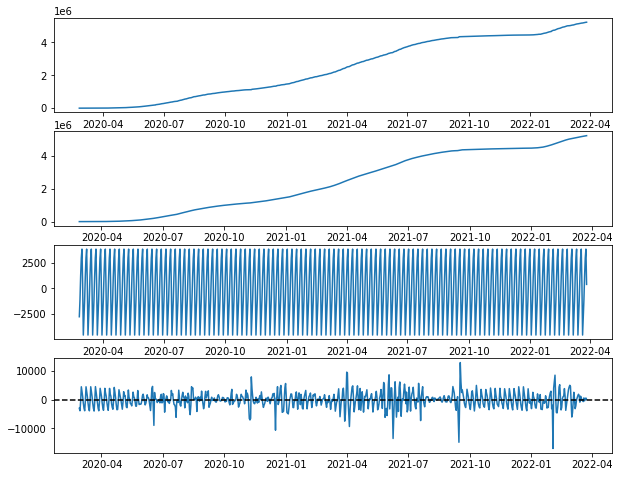

In [12]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10,8))

ax1.plot(res.observed)
ax2.plot(res.trend)
ax3.plot(res.seasonal)
ax4.plot(confirmados.index, res.resid)
ax4.axhline(0, linestyle='dashed', c='black')
plt.show

In [13]:
# ARIMA ()
modelo = auto_arima(confirmados)

In [19]:
fig = go.Figure(go.Scatter(
    x=confirmados.index, y=confirmados, name="Observados"
    
))

fig.add_trace(go.Scatter(
    x=confirmados.index, y=modelo.predict_in_sample(), name='Preditos'
))

fig.add_trace(go.Scatter(
    x=pd.date_range('2022-03-28','2022-10-03'), y=modelo.predict(189), name='Forecast'
))

fig.update_layout(title="Previsão de casos confirmados no estado de São Paulo para os próximos 189 dias")
fig.show()